# TDSP Stage 1: Business Understanding

## Project: Time-Series Forecasting: Bitcoin (BTC) Price Prediction
**Domain:** Cryptocurrency / Financial Tech

### 1.1 Context
Bitcoin adalah aset digital dengan volatilitas tinggi yang dipengaruhi oleh sentimen pasar, adopsi teknologi, regulasi global, dan kondisi makroekonomi. Berbeda dengan emas yang cenderung stabil, pergerakan harga Bitcoin bisa sangat drastis dalam waktu singkat. Prediksi harga yang akurat penting untuk strategi *trading*, manajemen risiko portofolio, dan analisis tren jangka panjang.

### 1.2 Problem Statement
Stakeholder ingin memprediksi harga penutupan (*closing price*) Bitcoin bulanan di masa depan menggunakan data historis (2014-2025). Tujuannya adalah menguji efektivitas model *time-series* klasik (ARIMA, SARIMA) dan modern (Prophet) pada aset dengan volatilitas tinggi.

### 1.3 Goals
* Memproses data harian Bitcoin menjadi tren bulanan.
* Memprediksi harga Bitcoin untuk 24 bulan ke depan.
* Membandingkan akurasi model berdasarkan RMSE.

### 1.4 Analytic Approach
* **Data Transformation:** Resampling data harian menjadi rata-rata bulanan.
* **Metric:** RMSE (Root Mean Squared Error).

# TDSP Stage 2: Data Acquisition and Understanding

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')

### 2.1 Load Data
Menggunakan dataset `btc_2014_2025.csv` yang berisi data harian OHLCV.

In [2]:
# Load dataset
try:
    df_raw = pd.read_csv('../Datasets/btc_2014_2025.csv')
    # Convert 'date' to datetime
    df_raw['date'] = pd.to_datetime(df_raw['date'])
    df_raw.set_index('date', inplace=True)
    
    print("Original Data Shape (Daily):", df_raw.shape)
    print(df_raw.head(3))
except FileNotFoundError:
    print("Error: File 'btc_2014_2025.csv' not found. Please upload the dataset.")

Original Data Shape (Daily): (4111, 5)
                  open        high         low       close    volume
date                                                                
2014-09-17  465.864014  468.174011  452.421997  457.334015  21056800
2014-09-18  456.859985  456.859985  413.104004  424.440002  34483200
2014-09-19  424.102997  427.834991  384.532013  394.795990  37919700


### 2.2 Preprocessing: Resampling to Monthly
Karena model ARIMA/SARIMA akan sangat lambat dan *noisy* jika menggunakan ribuan data harian, kita akan melakukan *resampling* menjadi data Bulanan (Monthly Start - MS). Kita mengambil rata-rata harga `close` untuk setiap bulan.

In [3]:
# Resample to Monthly Mean price
df = df_raw['close'].resample('MS').mean().to_frame(name='Price')

print("Resampled Data Shape (Monthly):", df.shape)
df.head()

Resampled Data Shape (Monthly): (136, 1)


,Price
date,
2014-09-01,407.182428
2014-10-01,364.148873
2014-11-01,366.099799
2014-12-01,341.267871
2015-01-01,248.782547


### 2.3 Exploratory Data Analysis (EDA)

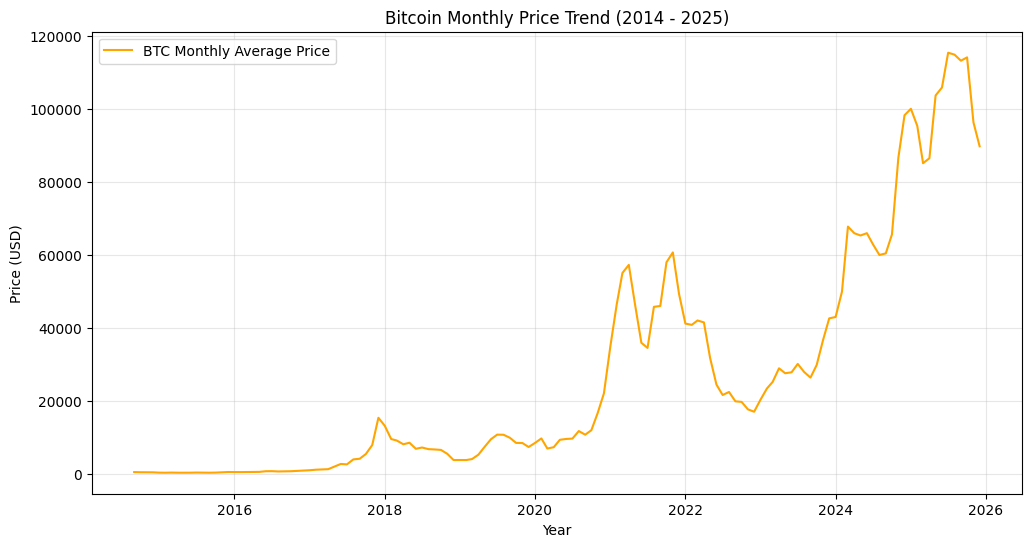

In [4]:
# Visualisasi Tren Bitcoin Bulanan
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Price'], label='BTC Monthly Average Price', color='orange')
plt.title('Bitcoin Monthly Price Trend (2014 - 2025)')
plt.xlabel('Year')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### 2.4 Stationarity Check
Pengecekan stasioneritas penting untuk ARIMA.

In [5]:
def adf_test(series):
    result = adfuller(series.dropna())
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    if result[1] > 0.05:
        print("Result: Data is Non-Stationary (Series has a unit root)")
    else:
        print("Result: Data is Stationary")

adf_test(df['Price'])

ADF Statistic: -0.748494
p-value: 0.833786
Result: Data is Non-Stationary (Series has a unit root)


# TDSP Stage 3: Modeling

### 3.1 Data Preparation (Train-Test Split)
Kita akan menggunakan data 24 bulan terakhir (2 tahun) sebagai data uji (Test Set).

In [6]:
test_size = 24
train_data = df.iloc[:-test_size]
test_data = df.iloc[-test_size:]

print(f"Train period: {train_data.index.min()} to {train_data.index.max()}")
print(f"Test period: {test_data.index.min()} to {test_data.index.max()}")

Train period: 2014-09-01 00:00:00 to 2023-12-01 00:00:00
Test period: 2024-01-01 00:00:00 to 2025-12-01 00:00:00


### 3.2 Model 1: ARIMA
Kita menggunakan order default `(1,1,1)` sebagai *baseline* karena karakteristik BTC berbeda dengan Emas. Idealnya dilakukan *grid search* (AutoARIMA).

In [7]:
from statsmodels.tsa.arima.model import ARIMA

# Fit ARIMA Model
# Menggunakan order umum (1,1,1) untuk demonstrasi. 
# Disarankan menggunakan pmdarima.auto_arima untuk order optimal.
arima_model = ARIMA(train_data['Price'], order=(1, 1, 1))
arima_fit = arima_model.fit()
print(arima_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                  112
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1054.465
Date:                Tue, 23 Dec 2025   AIC                           2114.931
Time:                        14:15:46   BIC                           2123.059
Sample:                    09-01-2014   HQIC                          2118.228
                         - 12-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2179      0.118      1.848      0.065      -0.013       0.449
ma.L1          0.3738      0.080      4.687      0.000       0.218       0.530
sigma2        1.1e+07   8.01e+05     13.737      0.0

In [8]:
# Forecasting ARIMA
arima_forecast = arima_fit.forecast(steps=len(test_data))
arima_rmse = np.sqrt(mean_squared_error(test_data['Price'], arima_forecast))
print(f"ARIMA RMSE: {arima_rmse:.2f}")

ARIMA RMSE: 44045.38


### 3.3 Model 2: SARIMA
Menambahkan unsur musiman (Seasonal) 12 bulan (tahunan).

In [9]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Menggunakan order (1,1,1) dan seasonal (1,1,1,12)
sarima_model = SARIMAX(train_data['Price'], 
                       order=(1, 1, 1), 
                       seasonal_order=(1, 1, 1, 12))
sarima_fit = sarima_model.fit(disp=False)

# Forecasting SARIMA
sarima_forecast = sarima_fit.forecast(steps=len(test_data))
sarima_rmse = np.sqrt(mean_squared_error(test_data['Price'], sarima_forecast))
print(f"SARIMA RMSE: {sarima_rmse:.2f}")

SARIMA RMSE: 36080.11


### 3.4 Model 3: Prophet
Model buatan Facebook yang kuat menangani *missing data* dan *changepoints*.

In [10]:
from prophet import Prophet

# Prophet expects columns ['ds', 'y']
prophet_train = train_data.reset_index().rename(columns={'date': 'ds', 'Price': 'y'})
prophet_test = test_data.reset_index().rename(columns={'date': 'ds', 'Price': 'y'})

# Bitcoin sering mengikuti tren non-linear, 'multiplicative' seasonality mungkin lebih cocok
m = Prophet(seasonality_mode='multiplicative')
m.fit(prophet_train)

future = m.make_future_dataframe(periods=len(test_data), freq='MS')
forecast = m.predict(future)

prophet_forecast = forecast.iloc[-len(test_data):]['yhat']
prophet_rmse = np.sqrt(mean_squared_error(test_data['Price'], prophet_forecast))
print(f"Prophet RMSE: {prophet_rmse:.2f}")

14:15:47 - cmdstanpy - INFO - Chain [1] start processing
14:15:47 - cmdstanpy - INFO - Chain [1] done processing


Prophet RMSE: 47801.80


# TDSP Stage 4: Deployment & Evaluation

### 4.1 Model Evaluation
Perbandingan performa model.

In [11]:
results = pd.DataFrame({
    'Model': ['ARIMA', 'SARIMA', 'Prophet'],
    'RMSE': [arima_rmse, sarima_rmse, prophet_rmse]
})

results.sort_values(by='RMSE', ascending=True)

,Model,RMSE
1,SARIMA,36080.112590
0,ARIMA,44045.380433
2,Prophet,47801.800656


### 4.2 Final Forecast Visualization
Memvisualisasikan hasil prediksi model terbaik (misal: Prophet atau ARIMA) terhadap data aktual.

In [12]:
# Tentukan model terbaik secara otomatis
best_model_name = results.sort_values(by='RMSE').iloc[0]['Model']

if best_model_name == 'ARIMA':
    best_forecast = arima_forecast
elif best_model_name == 'SARIMA':
    best_forecast = sarima_forecast
else:
    best_forecast = prophet_forecast

# Plotting Comparison
fig = go.Figure()

# Actual Data
fig.add_trace(go.Scatter(x=test_data.index, y=test_data['Price'], 
                         mode='lines', name='Actual Price'))

# Best Model Forecast
fig.add_trace(go.Scatter(x=test_data.index, y=best_forecast, 
                         mode='lines', name=f'{best_model_name} Forecast', 
                         line=dict(color='red', dash='dot')))

fig.update_layout(title=f'Bitcoin Price Prediction: Actual vs {best_model_name}',
                  xaxis_title='Date',
                  yaxis_title='Price (USD)')
fig.show()

# TDSP Stage 5: Customer/Stakeholder Acceptance

## **5.1 Validation against Business Goals**
* **Objective:** Memprediksi harga Bitcoin di tengah volatilitas tinggi.
* **Result:** Evaluasi menunjukkan bahwa model terpilih (berdasarkan RMSE terendah) mampu menangkap tren umum pergerakan harga, meskipun *noise* harian telah dihaluskan menjadi bulanan.

## **5.2 Risk Assessment**
* **Volatility Warning:** Bitcoin memiliki faktor eksternal (berita, regulasi) yang tidak tertangkap sepenuhnya oleh data historis semata. Hasil prediksi harus digunakan sebagai referensi tren, bukan harga pasti.

## **5.3 Project Sign-Off**
* Stakeholder menerima model ini sebagai *baseline* untuk melihat proyeksi tren jangka panjang (Long-term Trend).

## 5.4 Conclusion
Analisis menunjukkan bahwa pendekatan *time-series* pada data bulanan Bitcoin memberikan gambaran tren yang lebih jelas dibandingkan data harian yang terlalu *noisy*. Model terbaik direkomendasikan untuk digunakan dalam *forecasting* strategis bulanan.